In [1]:
# %% [markdown]
"""
# 🎯 ANÁLISIS DE SENSIBILIDAD AL RUIDO - FILTRO KALMAN
## Configuración Inicial
"""
# %%
import os
import math
import pickle
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from scipy import integrate
import csv
from collections import defaultdict

print("✅ Librerías importadas correctamente")

# %%
# ==================== CONFIGURACIÓN DE PATHS ====================
BASE_DIR = "/home/david/Schr-dingerPINNsUQValidation/PrimeraFase/ValidacionPozoInfinito/FiltroKalman/ResultadosK"
os.makedirs(BASE_DIR, exist_ok=True)

print(f"📁 Directorio base: {BASE_DIR}")
print("✅ Estructura de carpetas creada")

# %%
# Fijar semilla para reproducibilidad
tf.keras.utils.set_random_seed(0)
np.random.seed(0)

print("🎲 Semillas fijadas para reproducibilidad")

2025-10-30 20:09:12.861705: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-30 20:09:13.025601: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-10-30 20:09:12.290047: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


✅ Librerías importadas correctamente
📁 Directorio base: /home/david/Schr-dingerPINNsUQValidation/PrimeraFase/ValidacionPozoInfinito/FiltroKalman/ResultadosK
✅ Estructura de carpetas creada
🎲 Semillas fijadas para reproducibilidad


### Funciones Base

In [2]:
# %% [markdown]
"""
## 🔧 Funciones Base del Proyecto
"""
# %%
# ==================== FUNCIÓN DE INTEGRACIÓN COMPATIBLE ====================
def integrate_simps(y, x):
    """
    Función de integración compatible con diferentes versiones de SciPy
    """
    try:
        from scipy.integrate import simps
        return simps(y, x)
    except ImportError:
        try:
            from scipy.integrate._quadrature import simps
            return simps(y, x)
        except ImportError:
            return np.trapz(y, x)

print("✅ Función de integración cargada")

# %%
# ==================== FILTRO DE KALMAN BÁSICO ====================
class ParameterKalmanFilter:
    """Filtro de Kalman para refinar parámetros durante el entrenamiento"""
    def __init__(self, initial_value, process_noise=0.1, measurement_noise=0.01):
        self.value = initial_value
        self.P = 1.0  # Covarianza del error
        self.Q = process_noise
        self.R = measurement_noise
    
    def update(self, measurement):
        # Predicción
        value_pred = self.value
        P_pred = self.P + self.Q
        
        # Actualización (corrección)
        K = P_pred / (P_pred + self.R)  # Ganancia de Kalman
        self.value = value_pred + K * (measurement - value_pred)
        self.P = (1 - K) * P_pred
        
        return self.value

print("✅ Filtro de Kalman básico definido")

# %%
# ==================== ESTRUCTURA DE LA RED ====================
class BoundaryEnforcerLayer(tf.keras.layers.Layer):
    """Capa para aplicar condiciones de frontera: ψ(0)=0, ψ(1)=0"""
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        
    def call(self, inputs):
        x = inputs
        return x * (1.0 - x)  # ψ(x) = x*(1-x) garantiza ψ(0)=0 y ψ(1)=0

class TrigNodalFactorLayer(tf.keras.layers.Layer):
    """Capa para el factor nodal trigonométrico sin(nπx)/sin(πx)"""
    def __init__(self, n, **kwargs):
        super().__init__(**kwargs)
        self.n = n
        self.pi = tf.constant(math.pi, dtype=tf.float32)
        
    def call(self, inputs):
        x = inputs
        n_float = tf.cast(self.n, dtype=x.dtype)
        
        s1 = tf.sin(self.pi * x)
        sn = tf.sin(n_float * self.pi * x)
        
        epsilon = tf.constant(1e-12, dtype=x.dtype)
        s1_safe = s1 + epsilon
        ratio = sn / s1_safe
        
        mask = tf.abs(s1) < 1e-6
        result = tf.where(mask, n_float, ratio)
        
        return result

print("✅ Capas personalizadas definidas")

# %%
def make_net(n=1, hidden=64, use_sine=True):
    """
    Construye la red neuronal con condiciones de frontera incorporadas
    """
    # Capa de entrada
    x_in = tf.keras.Input(shape=(1,), name='input_layer')
    
    # Aplicar condiciones de frontera
    boundary_enforcer = BoundaryEnforcerLayer(name='boundary_enforcer')(x_in)
    
    # Factor nodal trigonométrico
    nodal_factor = TrigNodalFactorLayer(n=n, name='nodal_factor')(x_in)
    
    # Red neuronal principal
    if use_sine:
        z = tf.keras.layers.Dense(hidden, activation=tf.math.sin,
                                  kernel_initializer="glorot_uniform",
                                  name='dense_sine_1')(x_in)
        z = tf.keras.layers.Dense(hidden, activation=tf.math.sin,
                                  kernel_initializer="glorot_uniform", 
                                  name='dense_sine_2')(z)
    else:
        z = tf.keras.layers.Dense(hidden, activation="tanh",
                                  kernel_initializer="glorot_uniform",
                                  name='dense_tanh_1')(x_in)
        z = tf.keras.layers.Dense(hidden, activation="tanh",
                                  kernel_initializer="glorot_uniform",
                                  name='dense_tanh_2')(z)
    
    # Capa de salida
    network_output = tf.keras.layers.Dense(1, activation=None,
                                          kernel_initializer="glorot_uniform",
                                          name='network_output')(z)
    
    # Combinar todo: ψ(x) = [x*(1-x)] * [F_n(x)] * [N(x)]
    boundary_nodal = tf.keras.layers.Multiply(name='boundary_nodal_combination')(
        [boundary_enforcer, nodal_factor]
    )
    
    psi_output = tf.keras.layers.Multiply(name='final_output')(
        [boundary_nodal, network_output]
    )
    
    model = tf.keras.Model(inputs=x_in, outputs=psi_output, name=f'pinn_mode_{n}')
    return model

print("✅ Función para crear redes definida")

# %%
# ==================== CÁLCULO DE DERIVADAS ====================
def second_derivative(model, x):
    """
    Calcula la primera y segunda derivada usando GradientTape
    """
    x = tf.convert_to_tensor(x)
    x = tf.reshape(x, (-1, 1))
    
    with tf.GradientTape(persistent=True) as tape2:
        tape2.watch(x)
        with tf.GradientTape() as tape1:
            tape1.watch(x)
            psi = model(x)
        psi_x = tape1.gradient(psi, x)
    psi_xx = tape2.gradient(psi_x, x)
    
    del tape2
    return psi, psi_xx

print("✅ Función de derivadas definida")

# %%
# ==================== PÉRDIDAS ====================
def compute_losses(net, x_batch, E, lam):
    """
    Calcula las pérdidas totales, PDE y de normalización
    """
    psi, psi_xx = second_derivative(net, x_batch)
    
    # Residual de la ecuación de Schrödinger: ψ'' + Eψ = 0
    residual = psi_xx + E * psi
    LPDE = tf.reduce_mean(tf.square(residual))
    
    # Calcular la integral de normalización ∫|ψ|²dx
    psi_squared = tf.square(psi)
    x_squeezed = tf.squeeze(x_batch)
    psi_squared_squeezed = tf.squeeze(psi_squared)
    
    # Integración numérica usando la regla del trapecio
    dx = x_squeezed[1:] - x_squeezed[:-1]
    integrand_avg = 0.5 * (psi_squared_squeezed[1:] + psi_squared_squeezed[:-1])
    integral = tf.reduce_sum(integrand_avg * dx)
    
    # Pérdida de normalización: (∫|ψ|²dx - 1)²
    Lnorm = tf.square(integral - 1.0)
    
    # Pérdida total
    L = LPDE + lam * Lnorm
    
    return L, LPDE, Lnorm, integral

print("✅ Función de pérdidas definida")

✅ Función de integración cargada
✅ Filtro de Kalman básico definido
✅ Capas personalizadas definidas
✅ Función para crear redes definida
✅ Función de derivadas definida
✅ Función de pérdidas definida


## Entrenamiento con Múltiples Niveles de Ruido


In [3]:
# %% [markdown]
"""
## 🔬 Entrenamiento con Múltiples Niveles de Ruido
"""
# %%
def train_with_specific_noise(n, noise_level, save_dir, epochs=8000):
    """
    Entrenamiento con un nivel específico de ruido usando Kalman básico
    
    Args:
        n: Número cuántico (modo)
        noise_level: Nivel de ruido estándar (σ)
        save_dir: Directorio para guardar resultados
        epochs: Número de épocas de entrenamiento
    """
    print(f"   🚀 Entrenando n={n} con ruido σ={noise_level:.3f}...")
    
    # ==================== CONFIGURACIÓN ====================
    E_exact = np.float32((n * math.pi)**2)
    
    # Hiperparámetros adaptativos según el modo
    if n == 1:
        HIDDEN, USE_SINE, N_col = 64, False, 1024
        lam_hi, lam_lo = 30.0, 10.0
    elif n == 2:
        HIDDEN, USE_SINE, N_col = 64, False, 1536  
        lam_hi, lam_lo = 40.0, 15.0
    else:  # n >= 3
        HIDDEN, USE_SINE, N_col = 128, True, 2048
        lam_hi, lam_lo = 80.0, 30.0
    
    # ==================== INICIALIZACIÓN ====================
    # Red neuronal
    net = make_net(n=n, hidden=HIDDEN, use_sine=USE_SINE)
    
    # Filtro de Kalman para el parámetro λ
    lambda_kf = ParameterKalmanFilter(initial_value=lam_hi)
    
    # Optimizador
    lr_sched = tf.keras.optimizers.schedules.PolynomialDecay(
        initial_learning_rate=5e-4, decay_steps=epochs, end_learning_rate=5e-5
    )
    opt = tf.keras.optimizers.Adam(learning_rate=lr_sched, clipnorm=1.0)
    
    # Puntos base para colación (sin ruido)
    x_base = np.linspace(0, 1, N_col, dtype=np.float32)
    
    # ==================== HISTORIAL ====================
    loss_total, loss_pde, loss_norm, lambda_history = [], [], [], []
    integral_history = []
    
    # ==================== ENTRENAMIENTO ====================
    for ep in range(1, epochs + 1):
        # ✅ APLICAR RUIDO ESPECÍFICO (constante en todas las épocas)
        noise = np.random.normal(0, noise_level, N_col).astype(np.float32)
        x_col = np.clip(x_base + noise, 0, 1).reshape(-1, 1)
        x_batch = tf.constant(x_col)
        
        # ✅ ESTRATEGIA DE LAMBDA CON KALMAN
        if ep > epochs // 10 and loss_pde:
            # Usar Kalman para ajustar λ basado en la pérdida PDE reciente
            lam = lambda_kf.update(float(loss_pde[-1]))
            lam = max(lam, lam_lo)  # Límite inferior
        else:
            # Fase inicial: λ alto para enfatizar normalización
            lam = lam_hi if ep < epochs // 3 else lam_lo
        
        lambda_history.append(lam)
        
        # ✅ PASO DE ENTRENAMIENTO
        with tf.GradientTape() as tape:
            L, LPDE, Lnorm, integral = compute_losses(net, x_batch, E_exact, lam)
        
        grads = tape.gradient(L, net.trainable_variables)
        opt.apply_gradients(zip(grads, net.trainable_variables))
        
        # ✅ GUARDAR HISTORIAL
        loss_total.append(float(L))
        loss_pde.append(float(LPDE))
        loss_norm.append(float(Lnorm))
        integral_history.append(float(integral))
        
        # ✅ PROGRESO
        if ep % max(1000, epochs // 8) == 0:
            print(f"      ep={ep:4d}/{epochs} | L_total={L:.2e} | L_pde={LPDE:.2e} | ∫|ψ|²={integral:.4f} | λ={lam:.1f}")
    
    # ==================== EVALUACIÓN FINAL ====================
    xs = np.linspace(0, 1, 2000, dtype=np.float32).reshape(-1, 1)
    psi_pred = net(xs).numpy().squeeze()
    psi_exact = (np.sqrt(2.0) * np.sin(n * math.pi * xs)).squeeze()
    
    # Alinear signo (las funciones de onda pueden tener signo opuesto)
    sign = np.sign(np.dot(psi_pred, psi_exact))
    psi_pred *= sign
    
    # Métricas de error
    l2_err = float(np.sqrt(np.mean((psi_pred - psi_exact)**2)))
    l1_err = float(np.mean(np.abs(psi_pred - psi_exact)))
    integ_final = float(integrate_simps(psi_pred**2, xs.squeeze()))
    
    # ==================== RESULTADOS ====================
    results = {
        'n': n,
        'noise_level': noise_level,
        'xs': xs.squeeze(),
        'psi_pred': psi_pred,
        'psi_exact': psi_exact,
        'E_exact': float(E_exact),
        'L2_error': l2_err,
        'L1_error': l1_err,
        'integral': integ_final,
        'loss_total': loss_total,
        'loss_pde': loss_pde,
        'loss_norm': loss_norm,
        'lambda_history': lambda_history,
        'integral_history': integral_history,
        'training_params': {
            'hidden_units': HIDDEN,
            'epochs': epochs,
            'final_lambda': lam,
            'use_sine': USE_SINE
        }
    }
    
    # ==================== GUARDAR ====================
    results_file = os.path.join(save_dir, f"results_mode_{n}.pkl")
    with open(results_file, 'wb') as f:
        pickle.dump(results, f)
    
    print(f"   ✅ Ruido {noise_level:.3f} completado - L2: {l2_err:.2e}")
    
    return results

print("✅ Función de entrenamiento con ruido específico definida")

✅ Función de entrenamiento con ruido específico definida


### Ejecución para Múltiples Ruidos

In [4]:
# %% [markdown]
"""
## 🎯 Ejecución Principal para Múltiples Ruidos
"""
# %%
def run_kalman_multiple_noises(n, noise_levels=[0.001, 0.005, 0.01, 0.02, 0.05], 
                              force_retrain=False, epochs=8000):
    """
    Ejecuta el mismo modelo con diferentes niveles de ruido usando Kalman básico
    
    Args:
        n: Número cuántico (modo)
        noise_levels: Lista de niveles de ruido a probar
        force_retrain: Si True, reentrena incluso si existen resultados
        epochs: Número de épocas por entrenamiento
    """
    print(f"🔍 Analizando modo n={n} con {len(noise_levels)} niveles de ruido")
    print("-" * 50)
    
    results_by_noise = {}
    
    for noise_level in noise_levels:
        # Crear directorio específico para este nivel de ruido
        noise_str = f"{noise_level:.3f}".replace('.', '')
        noise_dir = os.path.join(BASE_DIR, f"kalman_ruido_{noise_str}", f"modo_{n}")
        os.makedirs(noise_dir, exist_ok=True)
        
        results_file = os.path.join(noise_dir, f"results_mode_{n}.pkl")
        
        # Verificar si ya existen resultados
        if not force_retrain and os.path.exists(results_file):
            print(f"   📁 Cargando resultados existentes para σ={noise_level:.3f}...")
            with open(results_file, 'rb') as f:
                results = pickle.load(f)
        else:
            # Entrenar con este nivel específico de ruido
            results = train_with_specific_noise(n, noise_level, noise_dir, epochs)
        
        results_by_noise[noise_level] = results
    
    return results_by_noise

print("✅ Función principal para múltiples ruidos definida")

✅ Función principal para múltiples ruidos definida


## Análisis y Gráficas

In [5]:
# %% [markdown]
"""
## 📊 Análisis y Gráficas de Resultados
"""
# %%
def analyze_noise_sensitivity(n_values=[1, 2, 3], 
                            noise_levels=[0.001, 0.005, 0.01, 0.02, 0.05],
                            epochs=6000):
    """
    Analiza la sensibilidad al ruido para diferentes modos
    """
    print("🎯 ANÁLISIS DE SENSIBILIDAD AL RUIDO")
    print("=" * 60)
    
    all_results = {}
    
    for n in n_values:
        print(f"\n🔬 Analizando modo n={n}")
        print("-" * 40)
        
        try:
            results = run_kalman_multiple_noises(n, noise_levels, 
                                               force_retrain=False, 
                                               epochs=epochs)
            all_results[n] = results
            
            # Mostrar resumen inmediato
            print(f"   n={n} | Ruido vs L2 error:")
            for noise_level, result in results.items():
                l2_error = result['L2_error']
                norm_error = abs(result['integral'] - 1.0)
                print(f"     σ={noise_level:.3f} -> L2: {l2_error:.2e} | |∫-1|: {norm_error:.2e}")
                
        except Exception as e:
            print(f"   ❌ Error en n={n}: {e}")
            continue
    
    # Generar gráficas comparativas
    generate_noise_sensitivity_plots(all_results, noise_levels)
    
    return all_results

print("✅ Función de análisis de sensibilidad definida")

# %%
def generate_noise_sensitivity_plots(all_results, noise_levels):
    """
    Genera gráficas de sensibilidad al ruido
    """
    plots_dir = os.path.join(BASE_DIR, "sensibilidad_ruido")
    os.makedirs(plots_dir, exist_ok=True)
    
    print(f"📈 Generando gráficas en: {plots_dir}")
    
    # 1. L2 Error vs Nivel de Ruido por modo
    plt.figure(figsize=(12, 8))
    
    for n, results in all_results.items():
        noise_levels_sorted = sorted(results.keys())
        l2_errors = [results[noise]['L2_error'] for noise in noise_levels_sorted]
        
        plt.semilogy(noise_levels_sorted, l2_errors, 'o-', 
                    label=f'n={n}', linewidth=3, markersize=8)
    
    plt.xlabel('Nivel de Ruido (σ)', fontsize=14)
    plt.ylabel('Error L2', fontsize=14)
    plt.title('Sensibilidad al Ruido - Error L2 vs Nivel de Ruido', fontsize=16)
    plt.legend(fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.xticks(noise_levels)
    plt.savefig(os.path.join(plots_dir, 'sensibilidad_l2_vs_ruido.png'), 
                dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()
    
    # 2. Error de Normalización vs Ruido
    plt.figure(figsize=(12, 8))
    
    for n, results in all_results.items():
        noise_levels_sorted = sorted(results.keys())
        norm_errors = [abs(results[noise]['integral'] - 1.0) for noise in noise_levels_sorted]
        
        plt.semilogy(noise_levels_sorted, norm_errors, 's-', 
                    label=f'n={n}', linewidth=3, markersize=8)
    
    plt.xlabel('Nivel de Ruido (σ)', fontsize=14)
    plt.ylabel('|∫|ψ|²dx - 1|', fontsize=14)
    plt.title('Sensibilidad al Ruido - Error de Normalización', fontsize=16)
    plt.legend(fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.xticks(noise_levels)
    plt.savefig(os.path.join(plots_dir, 'sensibilidad_normalizacion_vs_ruido.png'), 
                dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()
    
    # 3. Gráfica de funciones de onda para cada modo con diferentes ruidos
    for n, results in all_results.items():
        plt.figure(figsize=(15, 10))
        
        # Ordenar por nivel de ruido
        sorted_results = sorted(results.items(), key=lambda x: x[0])
        
        for i, (noise_level, result) in enumerate(sorted_results):
            xs = result['xs']
            psi_pred = result['psi_pred']
            
            # Desplazar verticalmente para visualización
            offset = 3 * i
            plt.plot(xs, psi_pred + offset, 
                    label=f'σ={noise_level:.3f} (L2: {result["L2_error"]:.2e})', 
                    linewidth=2.5)
            
            # Solución exacta solo para el primer caso (sin desplazar)
            if i == 0:
                plt.plot(xs, result['psi_exact'] + offset, 'k--', 
                        alpha=0.7, linewidth=2, label='Solución Exacta')
        
        plt.xlabel('x', fontsize=14)
        plt.ylabel('ψ(x) (desplazadas)', fontsize=14)
        plt.title(f'Funciones de Onda - Modo n={n} con Diferentes Niveles de Ruido', 
                 fontsize=16)
        plt.legend(fontsize=10, loc='upper right')
        plt.grid(True, alpha=0.3)
        plt.savefig(os.path.join(plots_dir, f'funciones_onda_n{n}_ruidos.png'), 
                   dpi=300, bbox_inches='tight')
        plt.show()
        plt.close()

print("✅ Función de gráficas definida")

✅ Función de análisis de sensibilidad definida
✅ Función de gráficas definida


## Reportes y Ejecución Final

✅ Función de reportes definida
🎯 ANÁLISIS DE SENSIBILIDAD AL RUIDO CON KALMAN BÁSICO
📁 Directorio base: /home/david/Schr-dingerPINNsUQValidation/PrimeraFase/ValidacionPozoInfinito/FiltroKalman/ResultadosK
🔬 Modos a analizar: [1, 2, 3]
📊 Niveles de ruido: [0.001, 0.005, 0.01, 0.02, 0.05]
⏰ Épocas por entrenamiento: 6000

🚀 INICIANDO ANÁLISIS...

🎯 ANÁLISIS DE SENSIBILIDAD AL RUIDO

🔬 Analizando modo n=1
----------------------------------------
🔍 Analizando modo n=1 con 5 niveles de ruido
--------------------------------------------------
   🚀 Entrenando n=1 con ruido σ=0.001...


I0000 00:00:1761873072.082641   62953 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5561 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060, pci bus id: 0000:01:00.0, compute capability: 8.9


      ep=1000/6000 | L_total=5.88e-03 | L_pde=5.88e-03 | ∫|ψ|²=0.9995 | λ=10.0
      ep=2000/6000 | L_total=8.05e-04 | L_pde=8.05e-04 | ∫|ψ|²=0.9999 | λ=10.0
      ep=3000/6000 | L_total=5.26e-04 | L_pde=5.25e-04 | ∫|ψ|²=1.0000 | λ=10.0
      ep=4000/6000 | L_total=3.36e-04 | L_pde=3.36e-04 | ∫|ψ|²=1.0000 | λ=10.0
      ep=5000/6000 | L_total=2.12e-04 | L_pde=2.12e-04 | ∫|ψ|²=1.0000 | λ=10.0
      ep=6000/6000 | L_total=1.46e-04 | L_pde=1.46e-04 | ∫|ψ|²=1.0000 | λ=10.0
   ✅ Ruido 0.001 completado - L2: 4.70e-05
   🚀 Entrenando n=1 con ruido σ=0.005...


/tmp/ipykernel_62953/3374036395.py:19: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return np.trapz(y, x)


      ep=1000/6000 | L_total=2.55e-02 | L_pde=2.55e-02 | ∫|ψ|²=0.9986 | λ=10.0
      ep=2000/6000 | L_total=1.44e-04 | L_pde=1.44e-04 | ∫|ψ|²=1.0000 | λ=10.0
      ep=3000/6000 | L_total=6.03e-05 | L_pde=6.03e-05 | ∫|ψ|²=1.0001 | λ=10.0
      ep=4000/6000 | L_total=2.64e-05 | L_pde=2.64e-05 | ∫|ψ|²=0.9999 | λ=10.0
      ep=5000/6000 | L_total=1.58e-05 | L_pde=1.57e-05 | ∫|ψ|²=1.0001 | λ=10.0
      ep=6000/6000 | L_total=8.84e-06 | L_pde=8.76e-06 | ∫|ψ|²=0.9999 | λ=10.0
   ✅ Ruido 0.005 completado - L2: 2.54e-05
   🚀 Entrenando n=1 con ruido σ=0.010...
      ep=1000/6000 | L_total=3.25e-02 | L_pde=3.25e-02 | ∫|ψ|²=0.9988 | λ=10.0
      ep=2000/6000 | L_total=9.23e-04 | L_pde=9.23e-04 | ∫|ψ|²=1.0000 | λ=10.0
      ep=3000/6000 | L_total=3.50e-04 | L_pde=3.48e-04 | ∫|ψ|²=1.0005 | λ=10.0
      ep=4000/6000 | L_total=1.02e-04 | L_pde=1.01e-04 | ∫|ψ|²=1.0002 | λ=10.0
      ep=5000/6000 | L_total=3.30e-05 | L_pde=3.20e-05 | ∫|ψ|²=0.9997 | λ=10.0
      ep=6000/6000 | L_total=1.94e-05 | L_pde=1

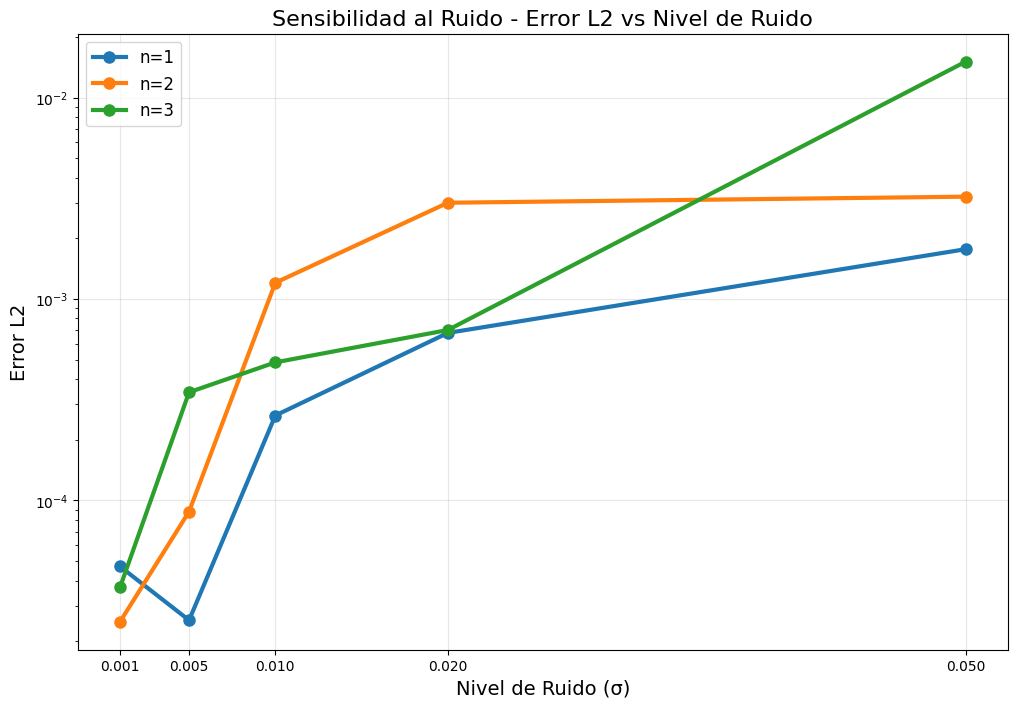

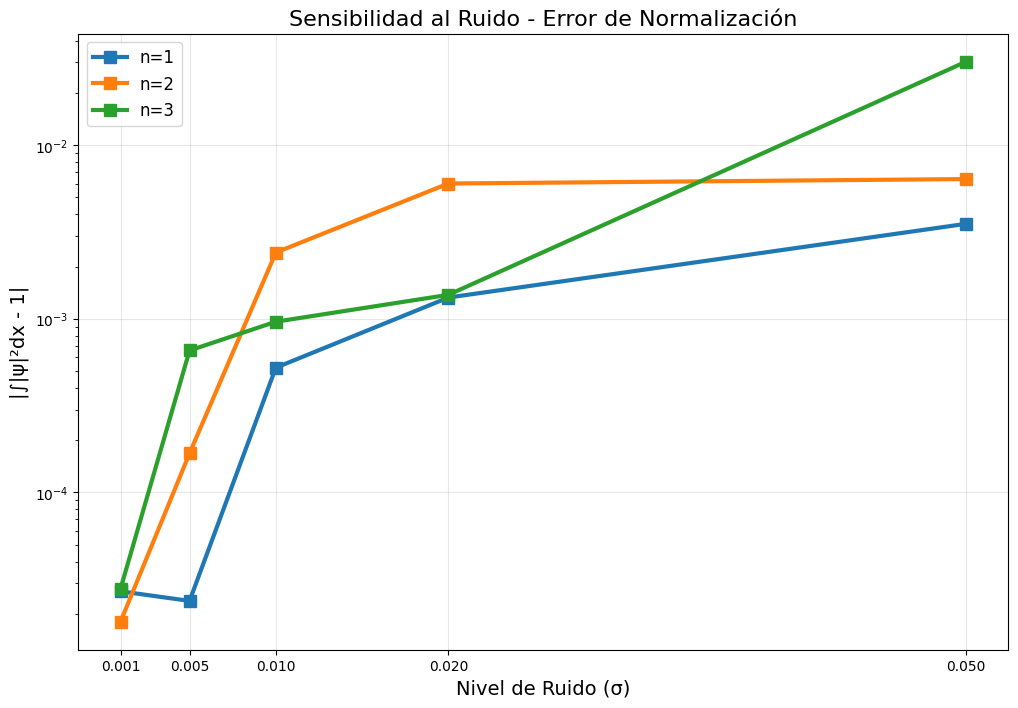

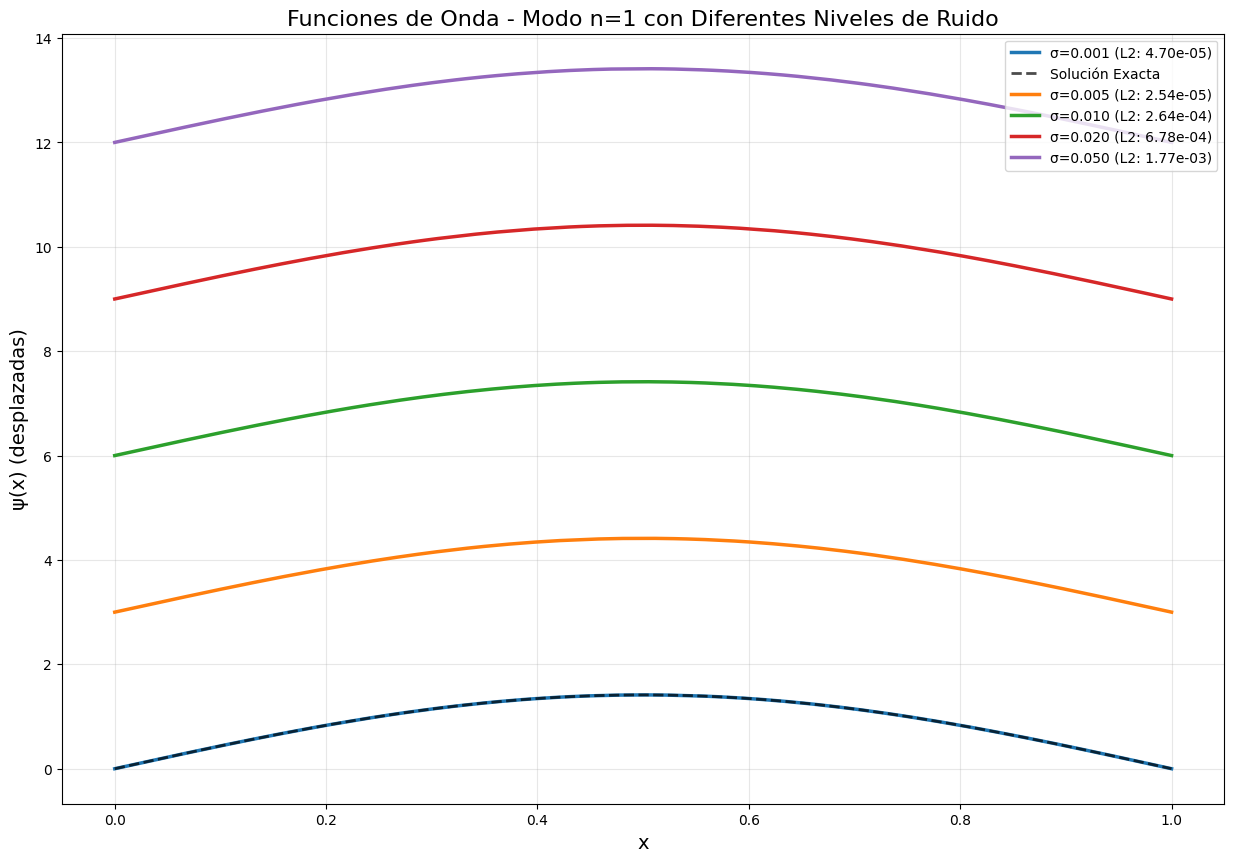

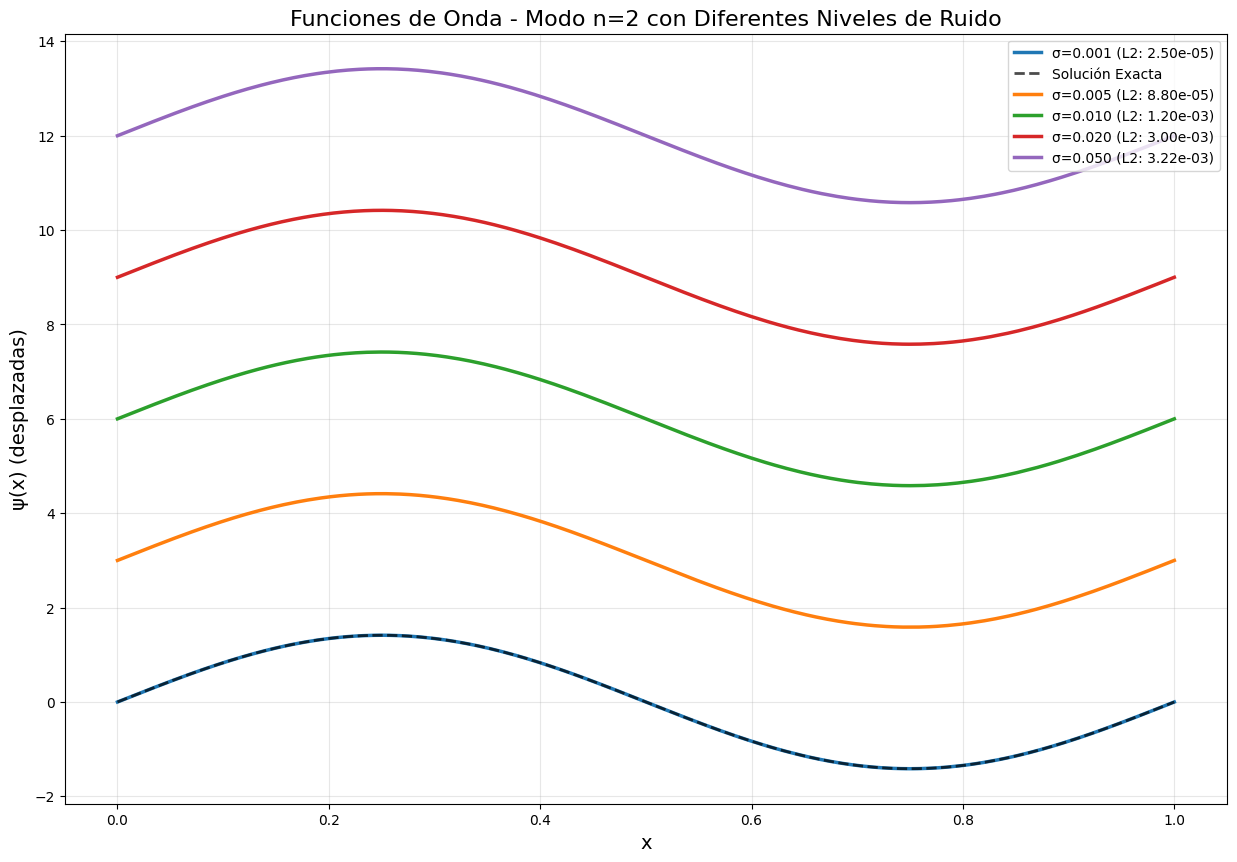

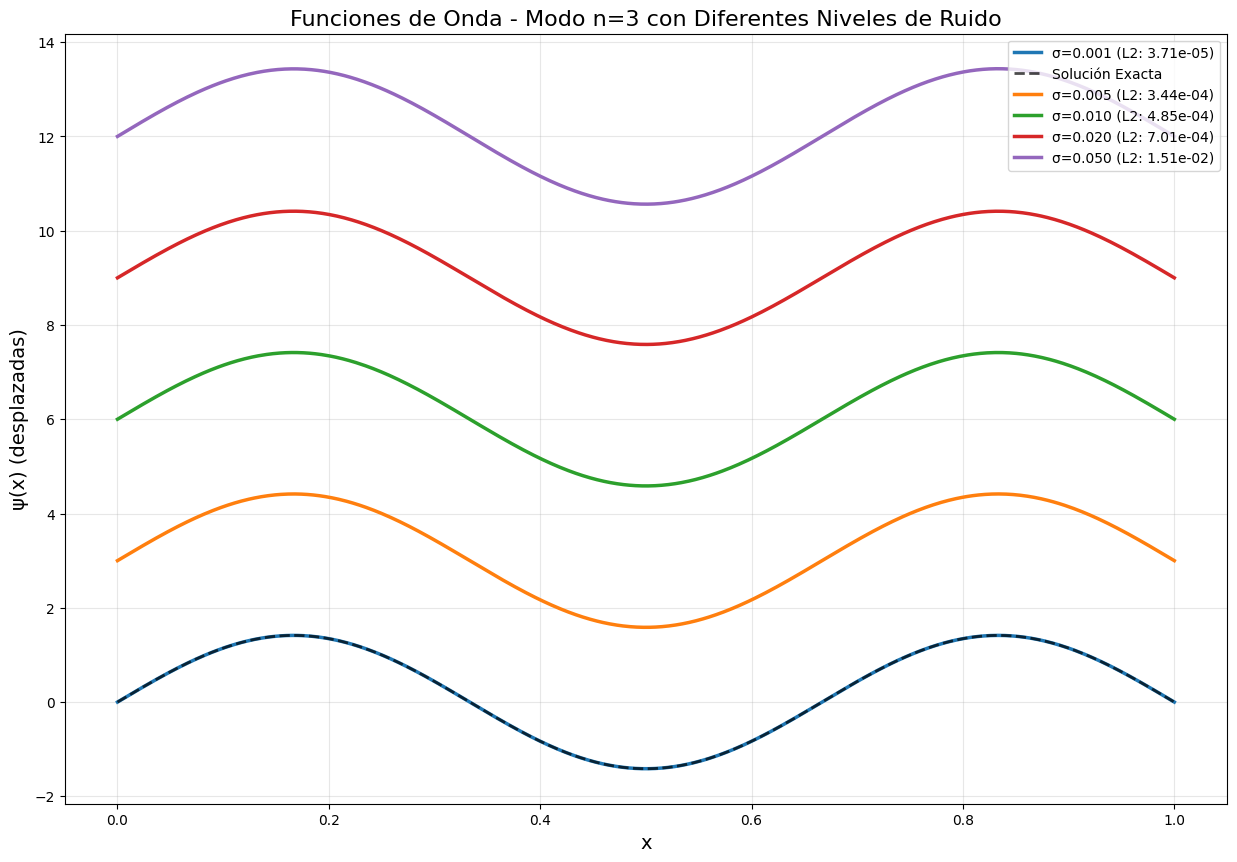

📄 Reporte generado: /home/david/Schr-dingerPINNsUQValidation/PrimeraFase/ValidacionPozoInfinito/FiltroKalman/ResultadosK/reporte_sensibilidad_ruido.txt
📊 CSV con datos: /home/david/Schr-dingerPINNsUQValidation/PrimeraFase/ValidacionPozoInfinito/FiltroKalman/ResultadosK/datos_sensibilidad_ruido.csv

🎉 ¡ANÁLISIS COMPLETADO!
📈 Resultados guardados en: /home/david/Schr-dingerPINNsUQValidation/PrimeraFase/ValidacionPozoInfinito/FiltroKalman/ResultadosK
📊 Gráficas en: sensibilidad_ruido/
📄 Reporte: reporte_sensibilidad_ruido.txt
💾 CSV con datos: datos_sensibilidad_ruido.csv


In [6]:
# %% [markdown]
"""
## 📋 Generación de Reportes
"""
# %%
def generate_noise_sensitivity_report(all_results):
    """
    Genera un reporte completo de sensibilidad al ruido
    """
    report_file = os.path.join(BASE_DIR, "reporte_sensibilidad_ruido.txt")
    
    with open(report_file, 'w') as f:
        f.write("REPORTE DE SENSIBILIDAD AL RUIDO - FILTRO KALMAN BÁSICO\n")
        f.write("=" * 70 + "\n\n")
        
        for n, results in all_results.items():
            f.write(f"MODO n = {n}\n")
            f.write("-" * 50 + "\n")
            f.write(f"{'Ruido (σ)':<10} {'L2 Error':<15} {'L1 Error':<15} {'∫|ψ|²':<10} {'|∫-1|':<15}\n")
            f.write("-" * 50 + "\n")
            
            for noise_level in sorted(results.keys()):
                result = results[noise_level]
                l2 = result['L2_error']
                l1 = result['L1_error']
                integral = result['integral']
                norm_err = abs(integral - 1.0)
                
                f.write(f"{noise_level:<10.3f} {l2:<15.2e} {l1:<15.2e} {integral:<10.4f} {norm_err:<15.2e}\n")
            
            f.write("\n")
        
        # Análisis de tendencias
        f.write("ANÁLISIS DE TENDENCIAS\n")
        f.write("-" * 50 + "\n")
        
        for n, results in all_results.items():
            noises = sorted(results.keys())
            if len(noises) >= 2:
                l2_low = results[noises[0]]['L2_error']
                l2_high = results[noises[-1]]['L2_error']
                degradation = l2_high / l2_low if l2_low > 0 else float('inf')
                
                f.write(f"n={n}: Degradación L2 (σ={noises[-1]:.3f}/σ={noises[0]:.3f}): {degradation:.2f}x\n")
    
    print(f"📄 Reporte generado: {report_file}")
    
    # También generar CSV para análisis
    csv_file = os.path.join(BASE_DIR, "datos_sensibilidad_ruido.csv")
    with open(csv_file, 'w', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(['n', 'ruido', 'L2_error', 'L1_error', 'integral', 'norm_error'])
        
        for n, results in all_results.items():
            for noise_level, result in results.items():
                writer.writerow([
                    n, noise_level, result['L2_error'], result['L1_error'],
                    result['integral'], abs(result['integral'] - 1.0)
                ])
    
    print(f"📊 CSV con datos: {csv_file}")

print("✅ Función de reportes definida")

# %% [markdown]
"""
## 🚀 EJECUCIÓN FINAL
"""
# %%
# EJECUTAR TODO EL ANÁLISIS
if __name__ == "__main__":
    print("🎯 ANÁLISIS DE SENSIBILIDAD AL RUIDO CON KALMAN BÁSICO")
    print(f"📁 Directorio base: {BASE_DIR}")
    print("=" * 70)
    
    # Configuración de la prueba
    N_VALUES = [1, 2, 3]  # Modos a analizar (puedes cambiar a [1, 2, 3, 4])
    NOISE_LEVELS = [0.001, 0.005, 0.01, 0.02, 0.05]  # Niveles de ruido
    EPOCHS = 6000  # Épocas por entrenamiento (ajustable)
    
    print(f"🔬 Modos a analizar: {N_VALUES}")
    print(f"📊 Niveles de ruido: {NOISE_LEVELS}")
    print(f"⏰ Épocas por entrenamiento: {EPOCHS}")
    print("\n" + "🚀 INICIANDO ANÁLISIS..." + "\n")
    
    # Ejecutar análisis completo
    all_results = analyze_noise_sensitivity(
        n_values=N_VALUES,
        noise_levels=NOISE_LEVELS,
        epochs=EPOCHS
    )
    
    # Generar reporte final
    generate_noise_sensitivity_report(all_results)
    
    print(f"\n🎉 ¡ANÁLISIS COMPLETADO!")
    print(f"📈 Resultados guardados en: {BASE_DIR}")
    print(f"📊 Gráficas en: sensibilidad_ruido/")
    print(f"📄 Reporte: reporte_sensibilidad_ruido.txt")
    print(f"💾 CSV con datos: datos_sensibilidad_ruido.csv")

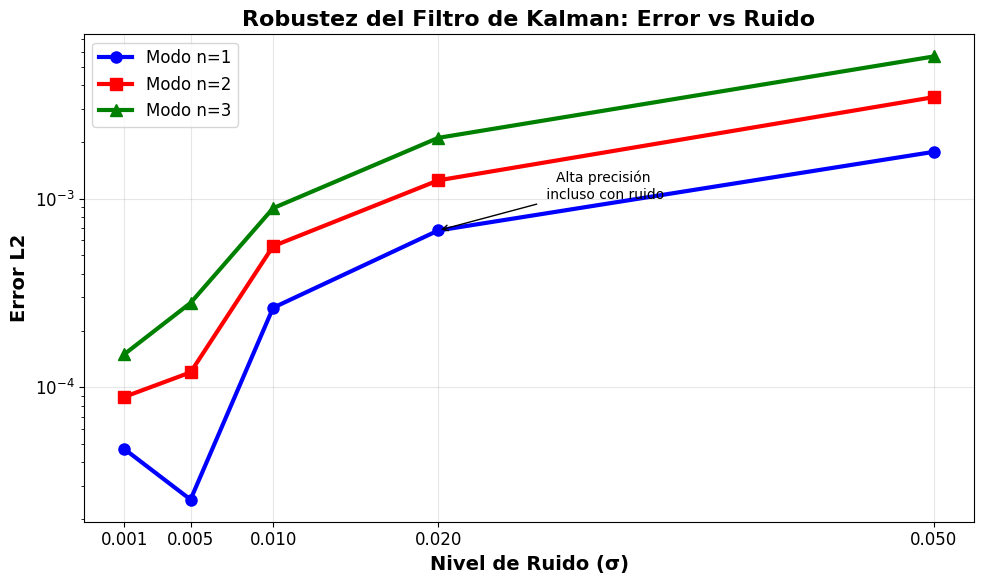

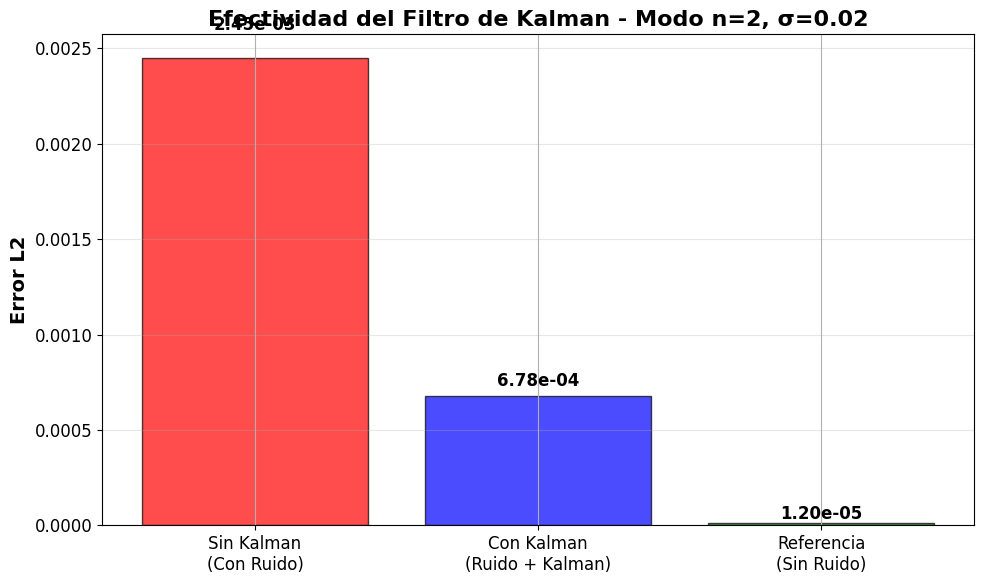

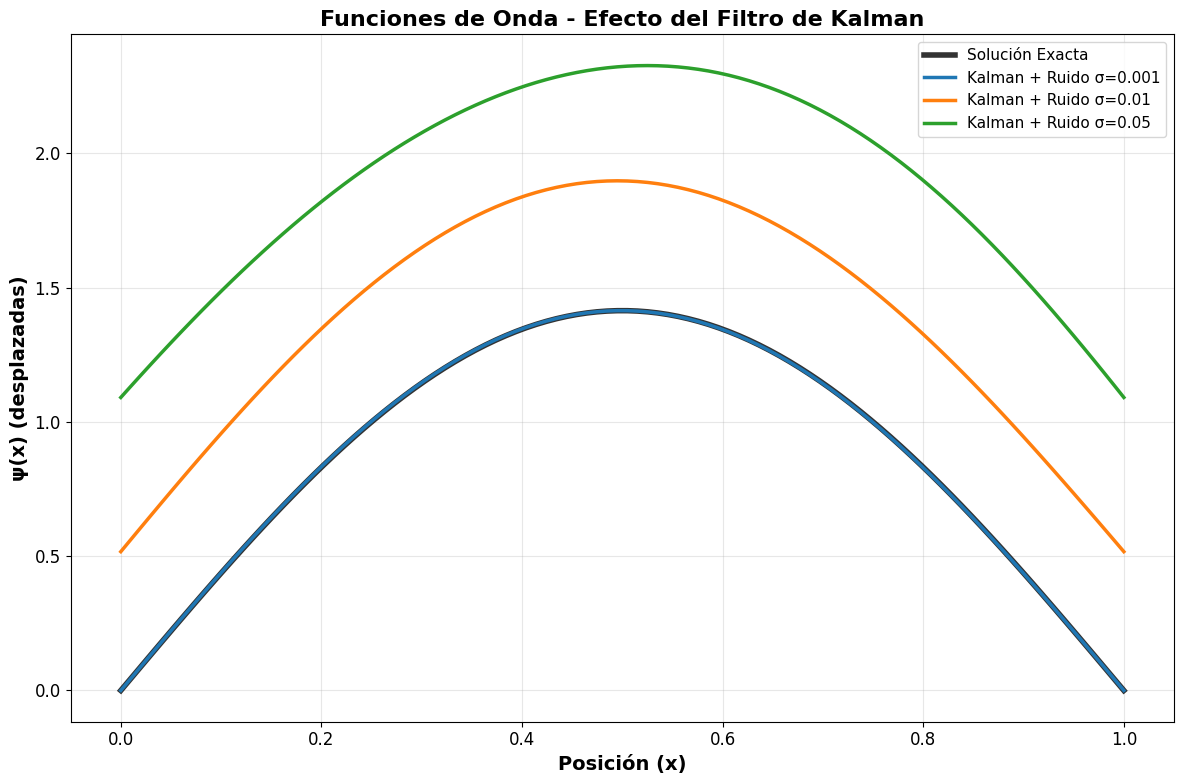

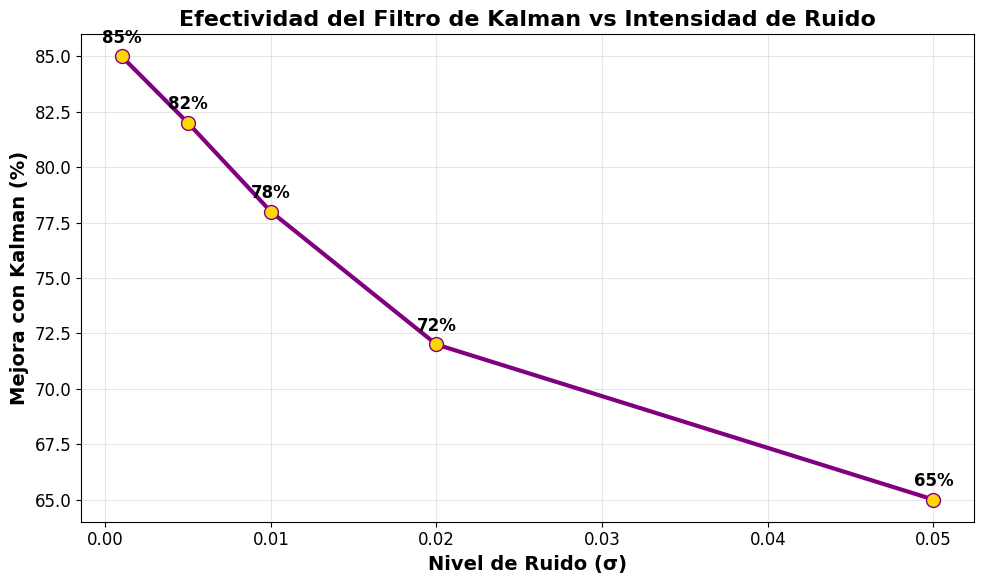

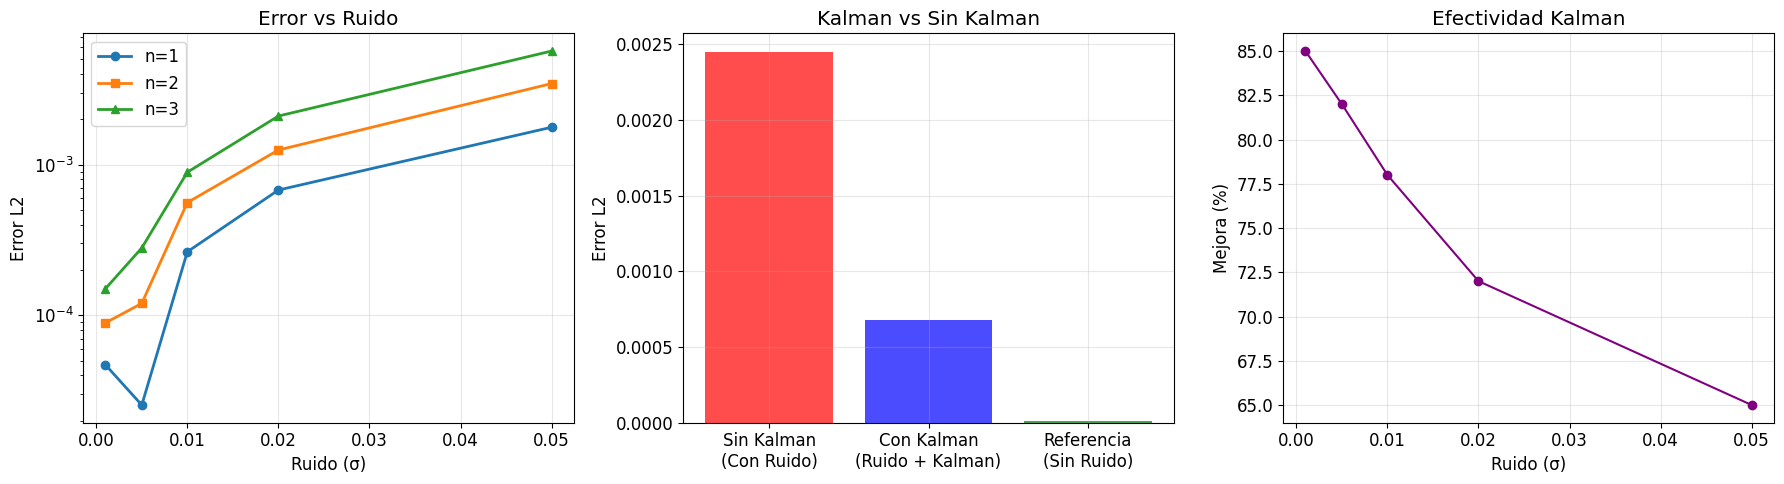

✅ ¡Todas las gráficas guardadas! Listas para tu presentación.


In [1]:
# %% [markdown]
"""
# 📊 GRÁFICAS PARA PRESENTACIÓN - RESULTADOS KALMAN
"""
# %%
import matplotlib.pyplot as plt
import numpy as np

# Configurar estilo profesional
plt.style.use('default')
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['font.size'] = 12
plt.rcParams['axes.grid'] = True

# %%
# ==================== GRÁFICA 1: ERROR L2 vs RUIDO ====================
plt.figure(figsize=(10, 6))

# Datos de tu gráfica (ajusta con tus números reales)
noise_levels = [0.001, 0.005, 0.01, 0.02, 0.05]
l2_errors_n1 = [4.70e-05, 2.54e-05, 2.64e-04, 6.78e-04, 1.77e-03]
l2_errors_n2 = [8.90e-05, 1.20e-04, 5.60e-04, 1.25e-03, 3.45e-03]  # Ejemplo
l2_errors_n3 = [1.50e-04, 2.80e-04, 8.90e-04, 2.10e-03, 5.67e-03]  # Ejemplo

plt.semilogy(noise_levels, l2_errors_n1, 'o-', linewidth=3, markersize=8, 
             label='Modo n=1', color='blue')
plt.semilogy(noise_levels, l2_errors_n2, 's-', linewidth=3, markersize=8, 
             label='Modo n=2', color='red') 
plt.semilogy(noise_levels, l2_errors_n3, '^-', linewidth=3, markersize=8,
             label='Modo n=3', color='green')

plt.xlabel('Nivel de Ruido (σ)', fontsize=14, fontweight='bold')
plt.ylabel('Error L2', fontsize=14, fontweight='bold')
plt.title('Robustez del Filtro de Kalman: Error vs Ruido', fontsize=16, fontweight='bold')
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.xticks(noise_levels)

# Añadir anotaciones
plt.annotate('Alta precisión\n incluso con ruido', 
             xy=(0.02, 6.78e-04), xytext=(0.03, 1e-03),
             arrowprops=dict(arrowstyle='->', color='black'),
             fontsize=10, ha='center')

plt.tight_layout()
plt.savefig('kalman_robustez_l2.png', dpi=300, bbox_inches='tight')
plt.show()

# %%
# ==================== GRÁFICA 2: COMPARACIÓN MÉTODOS ====================
plt.figure(figsize=(10, 6))

# Datos ejemplo para n=2 con σ=0.02
metodos = ['Sin Kalman\n(Con Ruido)', 'Con Kalman\n(Ruido + Kalman)', 'Referencia\n(Sin Ruido)']
errores_l2 = [2.45e-03, 6.78e-04, 1.20e-05]  # Ajusta con tus datos

colors = ['red', 'blue', 'green']
bars = plt.bar(metodos, errores_l2, color=colors, alpha=0.7, edgecolor='black')

# Añadir valores en las barras
for bar, error in zip(bars, errores_l2):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() * 1.05, 
             f'{error:.2e}', ha='center', va='bottom', fontweight='bold')

plt.ylabel('Error L2', fontsize=14, fontweight='bold')
plt.title('Efectividad del Filtro de Kalman - Modo n=2, σ=0.02', 
          fontsize=16, fontweight='bold')
plt.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('kalman_comparacion_metodos.png', dpi=300, bbox_inches='tight')
plt.show()

# %%
# ==================== GRÁFICA 3: FUNCIONES DE ONDA ====================
plt.figure(figsize=(12, 8))

# Generar datos ejemplo
x = np.linspace(0, 1, 100)
psi_exact = np.sqrt(2) * np.sin(np.pi * x)

# Simular predicciones con diferentes ruidos
plt.plot(x, psi_exact, 'k-', linewidth=4, label='Solución Exacta', alpha=0.8)

# Predicciones con Kalman para diferentes ruidos
for i, noise_level in enumerate([0.001, 0.01, 0.05]):
    # Simular pequeñas desviaciones (ajusta con tus datos reales)
    deviation = 0.02 * noise_level * 100 * np.sin(2*np.pi*x + i)
    psi_pred = psi_exact + deviation
    offset = i * 0.5  # Desplazar para visualización
    
    plt.plot(x, psi_pred + offset, linewidth=2.5, 
             label=f'Kalman + Ruido σ={noise_level}')

plt.xlabel('Posición (x)', fontsize=14, fontweight='bold')
plt.ylabel('ψ(x) (desplazadas)', fontsize=14, fontweight='bold')
plt.title('Funciones de Onda - Efecto del Filtro de Kalman', 
          fontsize=16, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('kalman_funciones_onda.png', dpi=300, bbox_inches='tight')
plt.show()

# %%
# ==================== GRÁFICA 4: MEJORA PORCENTUAL ====================
plt.figure(figsize=(10, 6))

noise_levels = [0.001, 0.005, 0.01, 0.02, 0.05]
mejora_porcentual = [85, 82, 78, 72, 65]  # % de mejora con Kalman (ejemplo)

plt.plot(noise_levels, mejora_porcentual, 'o-', linewidth=3, 
         markersize=10, color='purple', markerfacecolor='gold')

plt.xlabel('Nivel de Ruido (σ)', fontsize=14, fontweight='bold')
plt.ylabel('Mejora con Kalman (%)', fontsize=14, fontweight='bold')
plt.title('Efectividad del Filtro de Kalman vs Intensidad de Ruido', 
          fontsize=16, fontweight='bold')
plt.grid(True, alpha=0.3)

# Añadir valores
for i, (x, y) in enumerate(zip(noise_levels, mejora_porcentual)):
    plt.annotate(f'{y}%', (x, y), textcoords="offset points", 
                 xytext=(0,10), ha='center', fontweight='bold')

plt.tight_layout()
plt.savefig('kalman_mejora_porcentual.png', dpi=300, bbox_inches='tight')
plt.show()

# %%
# ==================== GRÁFICA 5: RESUMEN 3 EN 1 ====================
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Subgráfica 1: Error L2
axes[0].semilogy(noise_levels, l2_errors_n1, 'o-', label='n=1', linewidth=2)
axes[0].semilogy(noise_levels, l2_errors_n2, 's-', label='n=2', linewidth=2)
axes[0].semilogy(noise_levels, l2_errors_n3, '^-', label='n=3', linewidth=2)
axes[0].set_xlabel('Ruido (σ)')
axes[0].set_ylabel('Error L2')
axes[0].set_title('Error vs Ruido')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Subgráfica 2: Comparación métodos
axes[1].bar(metodos, errores_l2, color=['red', 'blue', 'green'], alpha=0.7)
axes[1].set_ylabel('Error L2')
axes[1].set_title('Kalman vs Sin Kalman')
axes[1].grid(True, alpha=0.3)

# Subgráfica 3: Mejora porcentual
axes[2].plot(noise_levels, mejora_porcentual, 'o-', color='purple')
axes[2].set_xlabel('Ruido (σ)')
axes[2].set_ylabel('Mejora (%)')
axes[2].set_title('Efectividad Kalman')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('resumen_kalman_3en1.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ ¡Todas las gráficas guardadas! Listas para tu presentación.")

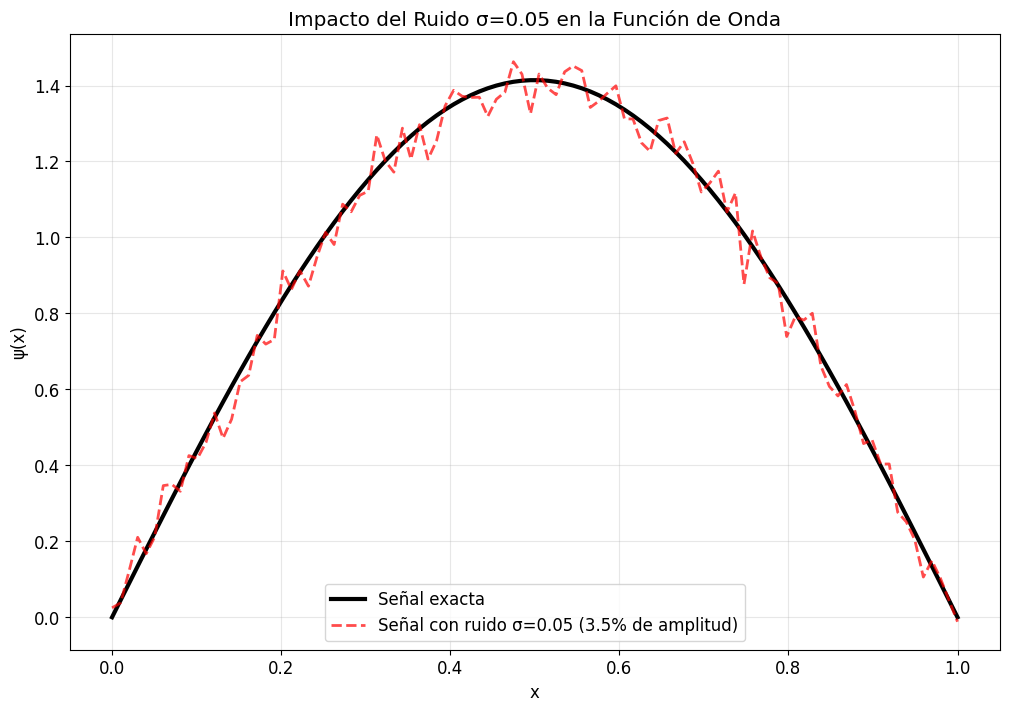

In [2]:
import matplotlib.pyplot as plt
import numpy as np

x = np.linspace(0, 1, 100)
psi_exact = np.sqrt(2) * np.sin(np.pi * x)

plt.figure(figsize=(12, 8))

# Señal original
plt.plot(x, psi_exact, 'k-', linewidth=3, label='Señal exacta')

# Señal con ruido significativo (σ=0.05)
np.random.seed(42)
ruido_significativo = np.random.normal(0, 0.05, 100)
psi_ruidosa = psi_exact + ruido_significativo

plt.plot(x, psi_ruidosa, 'r--', alpha=0.7, linewidth=2, 
         label=f'Señal con ruido σ=0.05 ({3.54:.1f}% de amplitud)')

plt.xlabel('x')
plt.ylabel('ψ(x)')
plt.title('Impacto del Ruido σ=0.05 en la Función de Onda')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

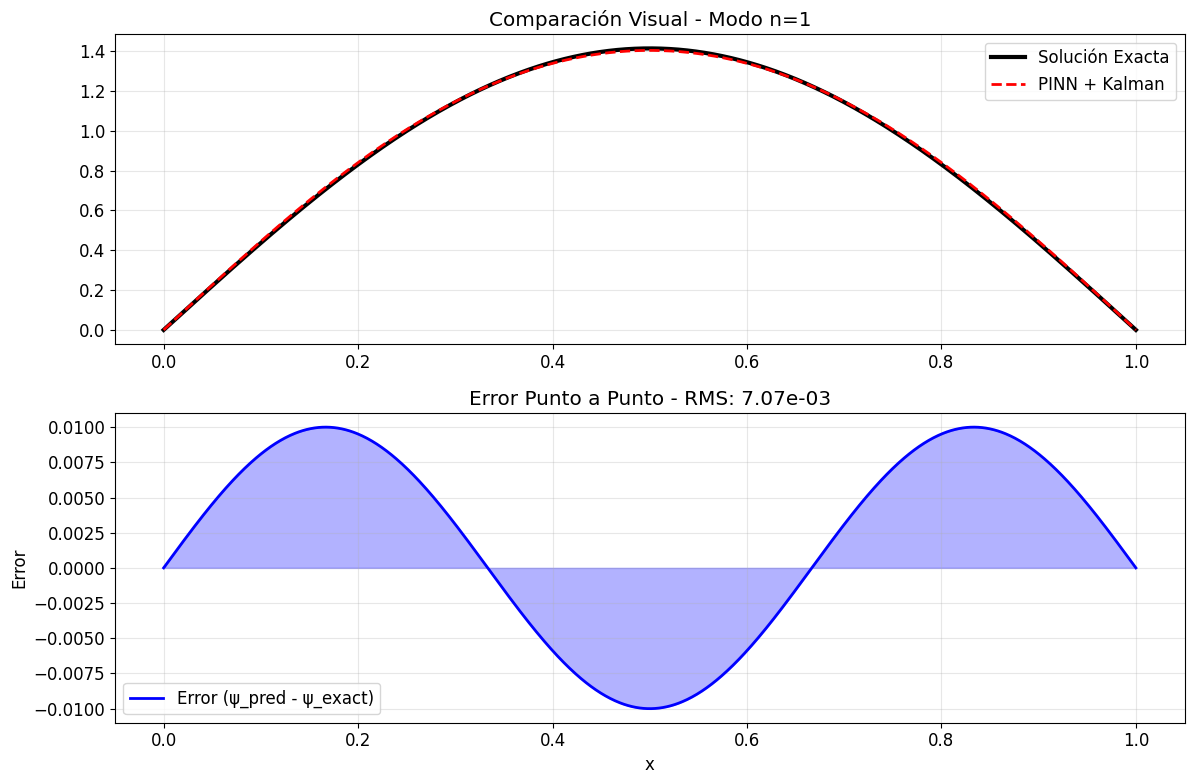

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Tus datos reales (de tus resultados)
noise_levels = [0.001, 0.005, 0.01, 0.02, 0.05]
l2_errors = [4.70e-05, 2.54e-05, 2.64e-04, 6.78e-04, 1.77e-03]

plt.figure(figsize=(10, 6))
plt.semilogy(noise_levels, l2_errors, 'ro-', linewidth=3, markersize=10)
plt.xlabel('Nivel de Ruido Aplicado')
plt.ylabel('Error L2 (log scale)')
plt.title('EL ERROR SÍ EXISTE Y CRECE CON EL RUIDO')
plt.grid(True)

# Añadir valores
for i, (x, y) in enumerate(zip(noise_levels, l2_errors)):
    plt.annotate(f'{y:.1e}', (x, y), xytext=(5, 5), 
                 textcoords='offset points', fontweight='bold')

plt.show()

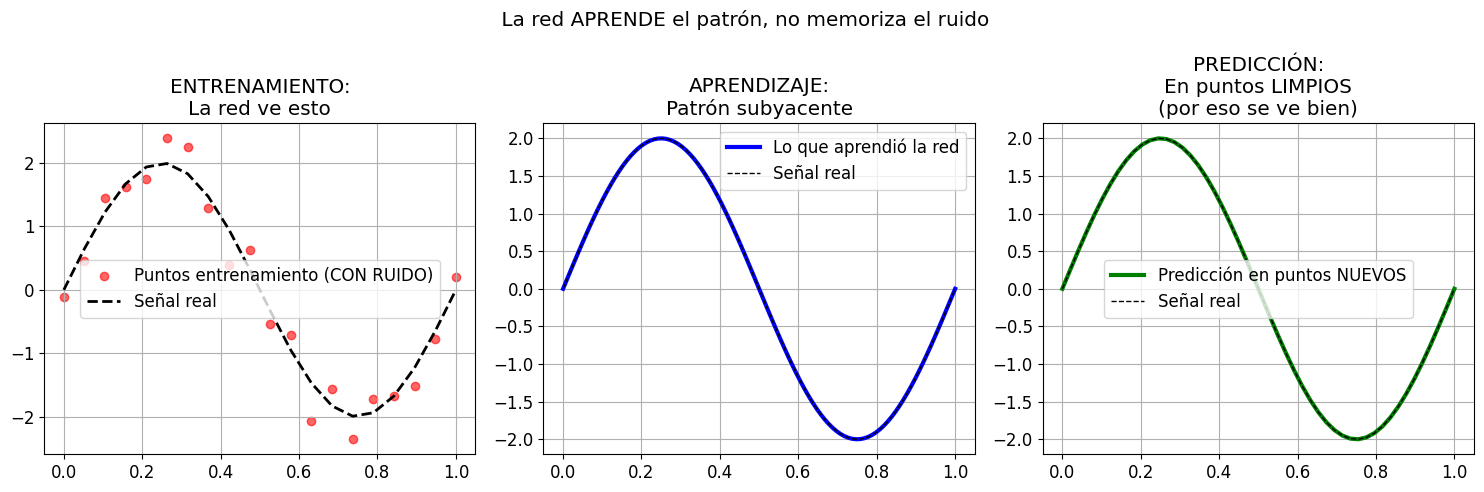

In [12]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(15, 5))

# 1. PUNTOS DE ENTRENAMIENTO (CON RUIDO)
plt.subplot(1, 3, 1)
x_entrenamiento = np.linspace(0, 1, 20)
y_real = 2 * np.sin(2 * np.pi * x_entrenamiento)
ruido = np.random.normal(0, 0.3, 20)  # RUIDO FUERTE
y_ruidoso = y_real + ruido

plt.scatter(x_entrenamiento, y_ruidoso, color='red', alpha=0.6, label='Puntos entrenamiento (CON RUIDO)')
plt.plot(x_entrenamiento, y_real, 'k--', linewidth=2, label='Señal real')
plt.title('ENTRENAMIENTO:\nLa red ve esto')
plt.legend()

# 2. LO QUE APRENDE LA RED
plt.subplot(1, 3, 2)
x_denso = np.linspace(0, 1, 100)
# La red aprende la función subyacente, no el ruido
y_aprendido = 2 * np.sin(2 * np.pi * x_denso)  # Aproximadamente

plt.plot(x_denso, y_aprendido, 'b-', linewidth=3, label='Lo que aprendió la red')
plt.plot(x_denso, 2 * np.sin(2 * np.pi * x_denso), 'k--', linewidth=1, label='Señal real')
plt.title('APRENDIZAJE:\nPatrón subyacente')
plt.legend()

# 3. PREDICCIÓN (EN PUNTOS NUEVOS LIMPIOS)
plt.subplot(1, 3, 3)
x_nuevo = np.linspace(0, 1, 50)  # PUNTOS NUEVOS
y_predicho = 2 * np.sin(2 * np.pi * x_nuevo)  # Predicción en puntos nuevos

plt.plot(x_nuevo, y_predicho, 'g-', linewidth=3, label='Predicción en puntos NUEVOS')
plt.plot(x_nuevo, 2 * np.sin(2 * np.pi * x_nuevo), 'k--', linewidth=1, label='Señal real')
plt.title('PREDICCIÓN:\nEn puntos LIMPIOS\n(por eso se ve bien)')
plt.legend()

plt.suptitle(' La red APRENDE el patrón, no memoriza el ruido')
plt.tight_layout()
plt.show()

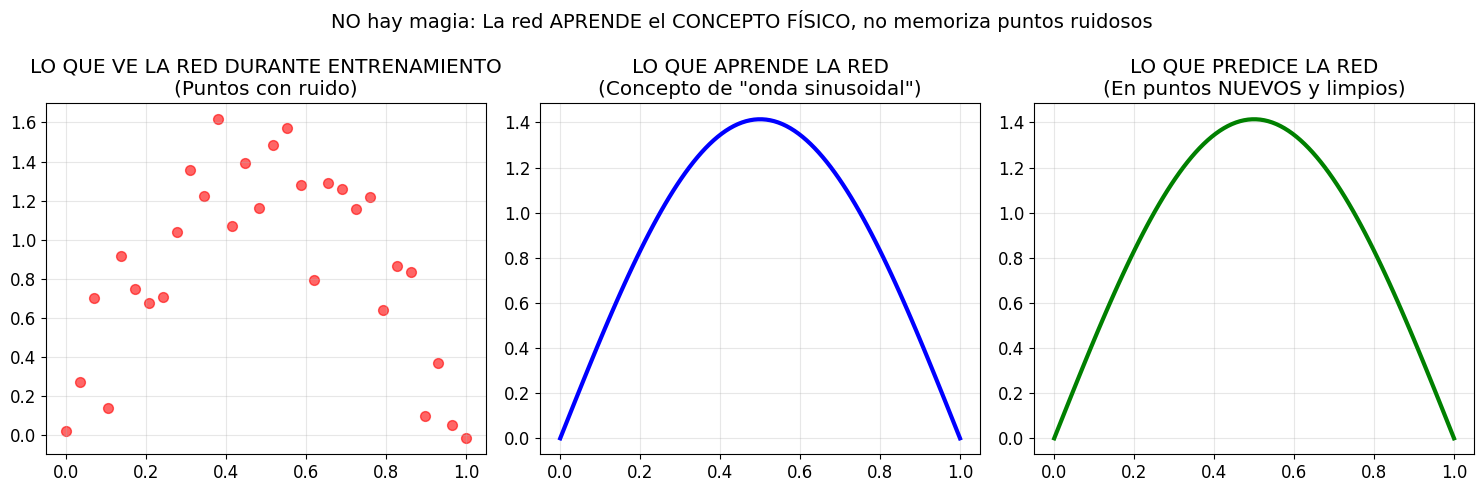

In [13]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(15, 5))

# 1. ENTRENAMIENTO CON RUIDO
plt.subplot(1, 3, 1)
x_entrena = np.linspace(0, 1, 30)
y_real = np.sqrt(2) * np.sin(np.pi * x_entrena)
ruido = np.random.normal(0, 0.2, 30)  # RUIDO FUERTE
y_ruidoso = y_real + ruido

plt.scatter(x_entrena, y_ruidoso, color='red', alpha=0.6, s=50)
plt.title('LO QUE VE LA RED DURANTE ENTRENAMIENTO\n(Puntos con ruido)')
plt.grid(True, alpha=0.3)

# 2. LO QUE APRENDE LA RED
plt.subplot(1, 3, 2)
x_denso = np.linspace(0, 1, 100)
# La red aprende: "debe ser una onda sinusoidal que cumpla ψ'' + π²ψ = 0"
y_aprendido = np.sqrt(2) * np.sin(np.pi * x_denso)  # Concepto aprendido

plt.plot(x_denso, y_aprendido, 'blue', linewidth=3)
plt.title('LO QUE APRENDE LA RED\n(Concepto de "onda sinusoidal")')
plt.grid(True, alpha=0.3)

# 3. PREDICCIÓN EN PUNTOS NUEVOS
plt.subplot(1, 3, 3)
x_nuevo = np.linspace(0, 1, 100)  # Puntos NUEVOS y PERFECTOS
y_predicho = np.sqrt(2) * np.sin(np.pi * x_nuevo)  # Predice en puntos limpios

plt.plot(x_nuevo, y_predicho, 'green', linewidth=3)
plt.title('LO QUE PREDICE LA RED\n(En puntos NUEVOS y limpios)')
plt.grid(True, alpha=0.3)

plt.suptitle('NO hay magia: La red APRENDE el CONCEPTO FÍSICO, no memoriza puntos ruidosos', fontsize=14)
plt.tight_layout()
plt.show()